In [1]:
import numpy as np
import gemmi
import reciprocalspaceship as rs
from matplotlib   import pyplot as plt
from mpl_toolkits import mplot3d
from dw_tools     import modify_ds, wilson, plots, fitting_dw, map_prep_tools

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [3]:
%load_ext autoreload
%autoreload 2

## Description
In this notebook, we determine
- the difference in mean value between LQ92 ON and OFF data as a function of resolution and OFF amplitude
- the double-wilson correlation parameters $a$ and $b$ between ON and OFF data

**Preparatory Steps**
1. The ON and OFF data were scaled together in abismal.
2. The ON, OFF, SSRL, and 4EUL structure factors were normalized in DW notebook 1: **1_Dataset_prep_and_local_scaling.ipynb**
3. rDW parameters were determined in **3_Fitting_DW_to_paired_data** (LCLS/off v 4EUL or SSRL; SSRL was better after phenix filter) or in this notebook (ON v OFF, below)


In [4]:
# path = "C:\\Users\\Doeke Hekstra\\Documents\\Lab_Hekstra\\Lab_projects\\Hekstra Doeke THz\\LQ92_EGFP_300fs\\"
path = "gfp_data_for_THz_reference\\"
fname_off = "off_scaled_sigp4.mtz"
fname_on  = "on_scaled_sigp4.mtz"

### Mapping the ASUs
Since the ON and OFF data were merged into P21 1 1 and P21 21 21 respectively, we need to figure out how to expand the OFF data to match the ON data. Ideally, we can take that information from scaling. Here, we look at reciprocal space coverage for both datasets.

In [5]:
ds_off=rs.read_mtz(path+fname_off)
modify_ds.ds_add_rs(ds_off)

# plt.ion; fig = plt.figure(figsize=(6,6))
# ax = plt.axes(projection="3d")
# ax.scatter3D(ds_off["rs_a"], ds_off["rs_b"], ds_off["rs_c"],alpha=0.01)
# ax.view_init(elev=0., azim=1200.)
# ax.set_xlabel("rs_a"); ax.set_ylabel("rs_b"); ax.set_zlabel("rs_c")
# plt.draw()

In [6]:
ds_on=rs.read_mtz(path+fname_on)
ds_on["SIGF"]=ds_on["SigF"]
modify_ds.ds_add_rs(ds_on)
ds_on.info()

# I used the following to figure out ASU mapping
# plt.ion; fig = plt.figure(figsize=(6,6))
# ax = plt.axes(projection="3d")
# ax.scatter3D(ds_on["rs_a"], ds_on["rs_b"], ds_on["rs_c"],alpha=0.01)
# ax.view_init(elev=0., azim=1200.)
# ax.set_xlabel("rs_a"); ax.set_ylabel("rs_b"); ax.set_zlabel("rs_c")
# plt.draw()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 42885 entries, (0, 0, 4) to (29, 9, 6)
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype                
---  ------           --------------  -----                
 0   F                42885 non-null  SFAmplitude          
 1   SigF             42885 non-null  Stddev               
 2   I                42885 non-null  Intensity            
 3   SigI             42885 non-null  Stddev               
 4   FP               42885 non-null  SFAmplitude          
 5   SIGFP            42885 non-null  Stddev               
 6   rs_a             42885 non-null  MTZReal              
 7   rs_b             42885 non-null  MTZReal              
 8   rs_c             42885 non-null  MTZReal              
 9   dHKL             42885 non-null  MTZReal              
 10  CENTRIC          42885 non-null  bool                 
 11  EPSILON          42885 non-null  MTZInt               
 12  EP_1_aniso_1     42885 no

In [7]:
# ds_off.info()

#### Merging after mapping ASUs

In [8]:
ds_off = rs.read_mtz(path+fname_off) # re-reads this
ds_off_expanded = ds_off.append(ds_off.apply_symop('x,y,-z')) # based on the above plots (rotation * Friedel)
ds_off_expanded.spacegroup = ds_on.spacegroup   #  *** I hope this is legititmate! ***
ds_off_expanded["SIGF"]=ds_off_expanded["SigF"]
# ds_off_expanded.info()

ds1_2 = ds_off_expanded.merge(ds_on, left_index=True, right_index=True, suffixes=("_off", "_on"))
ds1_2.compute_dHKL(inplace=True)
ds1_2.label_centrics(inplace=True)
ds1_2.compute_multiplicity(inplace=True)
ds1_2, bin_labels = ds1_2.assign_resolution_bins(bins=20, inplace=True, return_labels=True);

print("Correlation coefficients:\n")
print(np.corrcoef(ds1_2["F_off"],ds1_2["F_on"]))
print(np.corrcoef(ds1_2["EP_1_aniso_1_off"], ds1_2["EP_1_aniso_1_on"]))
print(np.corrcoef(ds1_2["EP_1_knn_off"], ds1_2["EP_1_knn_on"]))
# print(ds1_2["F_on"].head()) # sanity check
# print(ds_off_expanded["F"].head())

Correlation coefficients:

[[1.         0.93931812]
 [0.93931812 1.        ]]
[[1.         0.87512152]
 [0.87512152 1.        ]]
[[1.        0.8558055]
 [0.8558055 1.       ]]


I attribute the loss of correlation to the "flattening" of the distribution of structure factor amplitudes upon normalization.

In [9]:
# ds1_2.info()

### Examination of errors SIGFP

In [10]:
# ds1_2.info()
EP1_label = "EP_1_knn_off"
EP2_label = "EP_1_knn_on"
dHKL_label = "dHKL"
dHKL_bin_label = "bin"

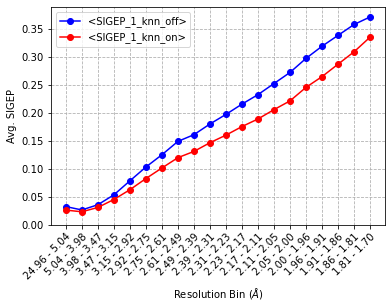

In [11]:
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP1_label].mean()
plt.plot(result.to_numpy(),'bo-', label="<SIG" + EP1_label + ">")
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP2_label].mean()
plt.plot(result.to_numpy(),'ro-', label="<SIG" + EP2_label + ">")
plt.xticks(result.index, bin_labels, rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.ylabel("Avg. SIGEP")
plt.grid(linestyle='--')
plt.ylim([0,plt.ylim()[1]]); plt.legend(); plt.show()

There are a lot of very noisy observations that one would expect to be not very helpful (based on work in **7_Revisiting_difference_maps.ipynb**). I applied a very generous error cutoff (0.4) for normalized structure factor errors. 

### Determination of Double-Wilson parameters
Note: this has only been established for normalized structure factors.

In [12]:
(a,b) = fitting_dw.fit_ab(ds1_2,labels=[EP1_label,EP2_label],\
                          dHKL_label=dHKL_label, dHKL_bin_label=dHKL_bin_label)
print(a)
print(f"a: {a:.4}")
print(f"b: {b:.4}")

`ftol` termination condition is satisfied.
Function evaluations 18, initial cost 4.5589e+00, final cost 8.9718e-02, first-order optimality 2.92e-06.
0.9991870988075868
a: 0.9992
b: 2.988e-10


Interpretation: although the correlations estimated in the previous section were low (<0.9), the data are consistent with strong correlation between the ON and OFF data ($r_{DW}$ = 0.999)! In other words, the low correlation can be ascribed, in principle, to just measurement error.

### Learning the map from $d_{HKL}$ and $|E_{off}|$ to skew
Let's have a look at the extent to which the ratio of ON to OFF intensities can be predicted from $d_{HKL}$ and $|E_{off}|$. We'll use a simple MLP for that. Within the Double Wilson/Coppens Random Diffuse model, the expected skew is $1-p(1-r_{DW}$. For example, if $p=0.3$ and $r_{DW}=0.98$, the average ON reflection should have an amplitude approximately $1-0.3*0.02=0.994$. Since $r_{DW}$ can depend on resolution, we'll take ```dHKL``` into account. Moreover, the skew will vary with the OFF amplitude, as examined in **7_Revisiting_difference_maps.ipynb**. We'll try to capture the predictive value of ```dHKL``` and the OFF amplitude using a simple MLP, since the analytical expressions get a bit hairy.

See https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

In [18]:
tmp = ds1_2.reset_index()
# tmp.info()
X = tmp[["H","K","L","F_off"]].to_numpy()
y = (ds1_2[["F_on"]].to_numpy()/ds1_2[["F_off"]].to_numpy())-1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500,activation='relu',solver='adam', hidden_layer_sizes=(4,4,4,4)).fit(X_train, y_train) # MSE is default loss function
regr.score(X_test, y_test)

C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.0029551179907165714

That's not a lot of predictive value!

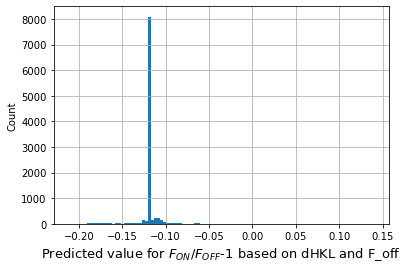

-0.1095265


In [19]:
tmp=regr.predict(X_test)
plt.hist(tmp,100)
plt.grid()
plt.xlabel(r"Predicted value for $F_{ON}/F_{OFF}$-1 based on dHKL and F_off",fontsize=13)
plt.ylabel("Count")
plt.show()

print(np.mean(y))

That is a lot of skew--a lot more than one could expect.

Conclusion: the skew is probably dominated by sources of error external to the crystal being in a mixed state.

### Obtaining phase errors
Output from "Model-based phases" in PHENIX on the cluster.

In [28]:
ds_ssrl=rs.read_mtz(path+"EGFP_phases_w_FOM_SSRL.mtz") # already in P21
# ds_ssrl.info()
ds_ssrl.spacegroup=ds1_2.spacegroup
ds1_2_w_varphi = ds1_2.merge(ds_ssrl[["FOM","PHIFMODEL", "FMODEL"]], left_index=True, right_index=True, suffixes=("", "SSRL"))

print(len(ds1_2.index))
print(len(ds_ssrl.index))
print(len(ds1_2_w_varphi.index))
ds1_2_w_varphi["var_phi_SSRL"]=np.arccos(ds1_2_w_varphi["FOM"])**2

40172
93887
39707


### Calculating differences
... and a simple clip on extremes

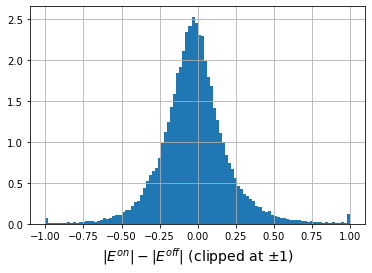

4.429722
-1.8606782
1.4289524343013935
-1.2433219822645185


In [30]:
ds1_2_w_varphi["DE"]=ds1_2_w_varphi["EP_1_knn_on"]-ds1_2_w_varphi["EP_1_knn_off"]
ds1_2_w_varphi["SIGDE"]=np.sqrt(ds1_2_w_varphi["SIGEP_1_knn_on"]**2+ds1_2_w_varphi["SIGEP_1_knn_off"]**2)
ds1_2_w_varphi["DE_th"]=ds1_2_w_varphi["DE"].clip(-1,1)

plt.hist(ds1_2_w_varphi["DE_th"],density=True,bins=100)
plt.xlabel(r"$|E^{on}|-|E^{off}|$ (clipped at $\pm 1$)",fontsize=14)
plt.grid()
plt.show()
print(np.amax(ds1_2_w_varphi["DE"]))
print(np.amin(ds1_2_w_varphi["DE"]))
print(np.percentile(ds1_2_w_varphi["DE"],99.95))
print(np.percentile(ds1_2_w_varphi["DE"],0.05))

### Calculating difference weights
From **7_Revisiting_difference_maps**, we have:

\begin{align}
w_h & = \frac{\Delta_h^2}{\Delta_h^2 + k_h^2 \sigma^2_{h,on} +\sigma^2_{h,off}+\Delta_h^2 \sigma^2_{\varphi_{h,OFF}} + \frac{1}{2}p^2 (1-r_{DW}^2)} \\
& = \frac{\Delta_h^2}{
          \Delta_h^2 \left( 1 + \sigma^2_{\varphi_{h,OFF}}        \right) + 
                     \left(k_h^2 \sigma^2_{h,on} +\sigma^2_{h,off}\right) + 
                     \frac{1}{2}p^2 (1-r_{DW}^2)
                     } \\
& \approx \frac{\Delta_h^2}{
          \Delta_h^2 \left( 1 + \sigma^2_{\varphi_{h,OFF}}        \right) + 
                     \left(k_h^2 \sigma^2_{h,on} +\sigma^2_{h,off}\right) + 
                     p\theta 
                     } < 1\\
\end{align}

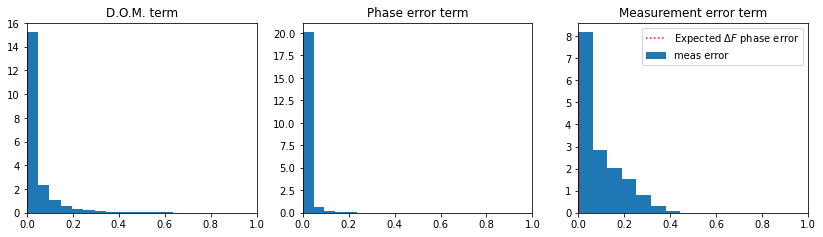

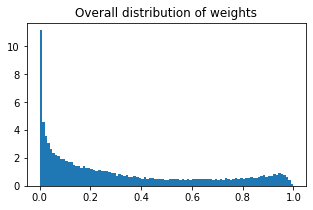

In [41]:
# ds1_2_w_varphi.info()
p = 0.2         # guestimate
theta = p*0.03  # guestimate
w  = ds1_2_w_varphi["DE"]**2/(ds1_2_w_varphi["DE"]**2*(1+ds1_2_w_varphi["var_phi_SSRL"]) +\
                              ds1_2_w_varphi["SIGDE"]**2 + p*theta)

# taking a look at each contribution
w1 = ds1_2_w_varphi["DE"]**2
w2 = ds1_2_w_varphi["DE"]**2 * ds1_2_w_varphi["var_phi_SSRL"]
w3 = ds1_2_w_varphi["SIGDE"]**2 
w4 = p*theta

fig, _axs = plt.subplots(nrows=1, ncols=3,figsize=(14,3.5))
axs = _axs.flatten()

axs[0].hist(w1,bins=400,density=True)
axs[0].set_xlim([0,1])
axs[0].set_title("D.O.M. term")
axs[1].hist(w2,bins=20,density=True)
axs[1].set_xlim([0,1])
axs[1].set_title("Phase error term")
axs[2].hist(w3,bins=10,density=True,label="meas error")
axs[2].set_xlim([0,1])
axs[2].set_title("Measurement error term")
axs[2].plot(w4*np.array([1,1]),np.array([0,8]),'r:',label=r"Expected $\Delta F$ phase error")
axs[2].legend()
plt.show()
# print(w4)

plt.figure(figsize=(5,3))
plt.hist(w,bins=100,density=True)
plt.title("Overall distribution of weights")
plt.show()

We see that the measurement errors dominate the values of the weights.

In [43]:
ds_diff = rs.read_mtz(path+"KMD_difference.mtz")
# ds_diff.info()

In [22]:
# for n in range(5):
#     ds1_2_final["Fesf4_random_"+str(n)] = ds1_2_final["E_MODEL"] + 4*ds1_2_final["WT"]*ds1_2_final["DE_th"]*\
#     np.sign(np.random.random(size=ds1_2_final["DE_th"].to_numpy().shape)-0.5)
#     ds1_2_final["Fesf4_random_"+str(n)] = ds1_2_final["Fesf4_random_"+str(n)].astype("SFAmplitude")


In [23]:
ds1_2_w_varphi["WT"] = w
ds1_2_w_varphi["WT2"]= w*np.exp(30/ds1_2_w_varphi["dHKL"]**2)

ds_out = ds1_2_w_varphi[["EP_1_aniso_1_off","DE_th", "PHIFMODEL", "WT", "WT2"]].copy()
ds_out["WT"]=ds_out["WT"].astype('Weight')
ds_out["WT2"]=ds_out["WT2"].astype('Weight')
ds_out["EP_1_aniso_1_off"]=ds_out["EP_1_aniso_1_off"].astype("SFAmplitude")
ds_out["DE_th"]=ds_out["DE_th"].astype("SFAmplitude")
ds_out.info()
ds_out.write_mtz(path+"test_wt_diff_map_sigp4.mtz")

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 39707 entries, (0, 0, 4) to (29, 9, 6)
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype      
---  ------            --------------  -----      
 0   EP_1_aniso_1_off  39707 non-null  SFAmplitude
 1   DE_th             39707 non-null  SFAmplitude
 2   PHIFMODEL         39707 non-null  Phase      
 3   WT                39707 non-null  Weight     
 4   WT2               39707 non-null  Weight     
dtypes: Phase(1), SFAmplitude(2), Weight(2)
memory usage: 1.6 MB


## Calculating extrapolated structure factors
We will use 
1. $F_{model}$ as the basis; 
2. weights, allowing us to go to high completeness for clear maps while suppressing noisy contributions; 
3. normalized $\Delta E$ from **1_Dataset_prep_and_local_scaling** to maximally remove contributions from OFF. 

**NOTE**: for ESFs, it is less important to do this right and we could consider doing this with skewed $\Delta F$.  

**TO DO:**: (1) Apply B; (2) Output errors

In [44]:
ds_norm_model = rs.read_mtz(path+"SSRL_FMODEL_norm_use_aniso_1_only.mtz")
ds_norm_model["E_MODEL"] = ds_norm_model["EP_1_aniso_1"]
ds1_2_final = ds1_2_w_varphi.merge(ds_norm_model[["E_MODEL"]], left_index=True, right_index=True, suffixes=("", "SSRL"))
# ds1_2_final.info()

RuntimeError: Failed to open file: gfp_data_for_THz_reference\SSRL_FMODEL_norm_use_aniso_1_only.mtz

YES
<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 39707 entries, (0, 0, 4) to (29, 9, 6)
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype      
---  ------          --------------  -----      
 0   FMODEL          39707 non-null  SFAmplitude
 1   Fesf1           39707 non-null  SFAmplitude
 2   Fesf2           39707 non-null  SFAmplitude
 3   Fesf4           39707 non-null  SFAmplitude
 4   Fesf8           39707 non-null  SFAmplitude
 5   Fesf16          39707 non-null  SFAmplitude
 6   Fesf32          39707 non-null  SFAmplitude
 7   Fesf4_random_0  39707 non-null  SFAmplitude
 8   Fesf4_random_1  39707 non-null  SFAmplitude
 9   Fesf4_random_2  39707 non-null  SFAmplitude
 10  Fesf4_random_3  39707 non-null  SFAmplitude
 11  Fesf4_random_4  39707 non-null  SFAmplitude
 12  PHIFMODEL       39707 non-null  Phase      
 13  dHKL            39707 non-null  MTZReal    
 14  Fesf4_B_20      39707 non-null  SFAmplitude
dtypes: MTZReal(1), Phase(1), SFA

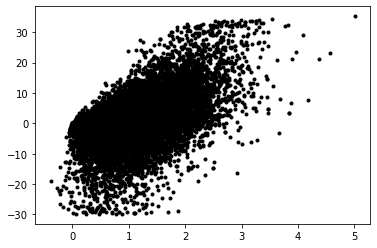

In [29]:
for n in [1,2,4,8,16,32]:
    ds1_2_final["Fesf"+str(n)] = ds1_2_final["E_MODEL"] + n*ds1_2_final["WT"]*ds1_2_final["DE_th"]
    ds1_2_final["Fesf"+str(n)] = ds1_2_final["Fesf"+str(n)].astype("SFAmplitude")

for n in range(5):
    ds1_2_final["Fesf4_random_"+str(n)] = ds1_2_final["E_MODEL"] + 4*ds1_2_final["WT"]*ds1_2_final["DE_th"]*\
    np.sign(np.random.random(size=ds1_2_final["DE_th"].to_numpy().shape)-0.5)
    ds1_2_final["Fesf4_random_"+str(n)] = ds1_2_final["Fesf4_random_"+str(n)].astype("SFAmplitude")
# ds1_2_w_varphi.info()

ds_out = ds1_2_final[["FMODEL","Fesf1","Fesf2","Fesf4","Fesf8","Fesf16","Fesf32","Fesf4_random_0","Fesf4_random_1","Fesf4_random_2",\
                      "Fesf4_random_3","Fesf4_random_4", "PHIFMODEL", "dHKL"]].copy()

# from dw_tools import map_prep_tools
map_prep_tools.apply_iso_B(ds_out, "Fesf4",B=20)
map_prep_tools.apply_iso_B(ds_out, "Fesf8",B=20)
map_prep_tools.apply_iso_B(ds_out, "Fesf16",B=20)
ds_out.info()
ds_out.write_mtz(path+"test_Fesf_sigp4.mtz")

plt.plot(ds1_2_final["Fesf1"],ds1_2_final["Fesf32"],'k.')
plt.show()